### Problem Description

We are provided with a Haberman's breast cancer survival dataset. The data contains information about patients who underwent a brest cancer operation from 1958 to 1970. Each entry contains info abour patien's age, year of operation, number of lymph nodes present and survival status.

Our goal is to make a predictive machine learning model which will be able to as accurately possible predict the survival status given the patien's data. 

### The Approach 

This project consists of the following steps:

1. Importing the data and performing exploratory data analysis by visualizing the data
2. Data preprocessing
3. Trying out different classification models to make prediction and improving their performance using hyperparameter tuning
4. Using various oversampling techniques to combat the dataset imbalance, and trying out different models

### Loading the Dataset

In [1]:
#we import some libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#we inspect tha data
data = pd.read_csv('../haberman.csv', header = None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       306 non-null    int64
 1   1       306 non-null    int64
 2   2       306 non-null    int64
 3   3       306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


We conclude that data is completely clean (no mising or corrupted entries), and that we have a relatively small dataset at hand. 

In [3]:
data.head()

,0,1,2,3
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


Unspecified colum names won't do us much good. We'll fix that.

In [4]:
data.columns = ['Patient Age', 'Year of Operation',
                'Number of Lymph Nodes','Survival Status']

data.head(10)

,Patient Age,Year of Operation,Number of Lymph Nodes,Survival Status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
5,33,58,10,1
6,33,60,0,1
7,34,59,0,2
8,34,66,9,2
9,34,58,30,1


`Survival Status` column has values of 1 and 2. 1 is a positive outcome, meaning that the patient has managed to live more than five years after the operation. 2 signifies that the patient has died within five years of the operation.

### EDA

Let's perform the exploratory data anaysis, to get some better data insights.

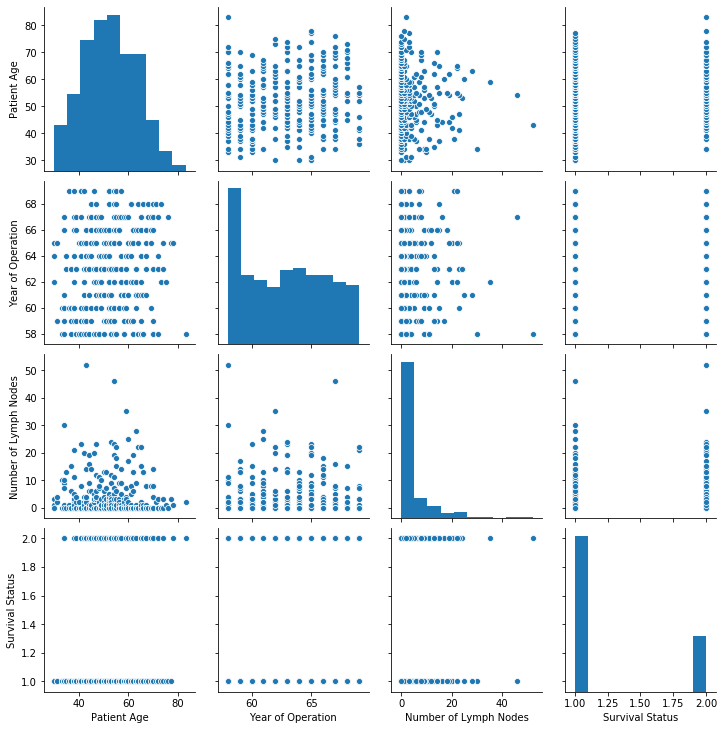

In [5]:
sns.pairplot(data);

We notice two things:

1. There are some outliers regarding the number of lymph nodes.
2. The dataset is quite imbalanced. There are almost three times more patients with positive survival outcome. 

We will throw out the outilers now, and handle the imbalance later.

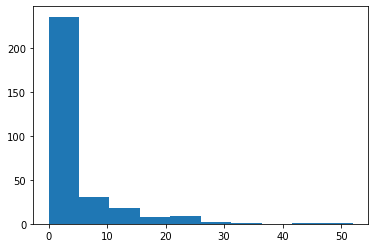

In [6]:
plt.hist(data['Number of Lymph Nodes']);

In [7]:
data = data[(data['Number of Lymph Nodes'] <= 40)]

We consider all the entries having mora than 40 lymph nodes as outliers.

And now we continue with our exploratory analysis.

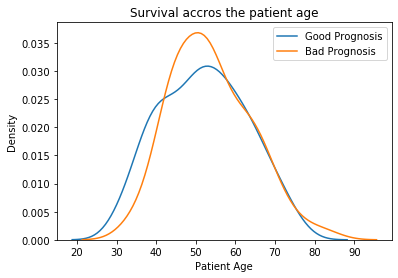

In [8]:
for surv_stat in [1,2]:
    
    sub_data = data[data['Survival Status'] == surv_stat]
    sns.kdeplot(sub_data['Patient Age'], label = surv_stat)
    
plt.xlabel('Patient Age'), plt.ylabel('Density');
plt.title('Survival accros the patient age');
plt.legend(labels = ['Good Prognosis', 'Bad Prognosis']);

Not much can be concluded here: mainly because that data is not separable. We can see that patients in their fourties are more likely to have a bad outcome, but the difference is not that significant.

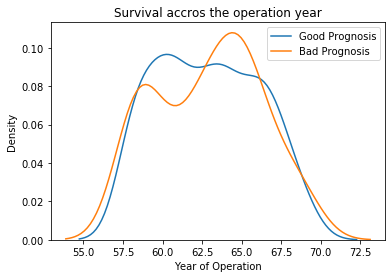

In [9]:
for surv_stat in [1,2]:
    
    sub_data = data[data['Survival Status'] == surv_stat]
    
    sns.kdeplot(sub_data['Year of Operation'], label = surv_stat)
    
plt.xlabel('Year of Operation'), plt.ylabel('Density');
plt.title('Survival accros the operation year');
plt.legend(labels = ['Good Prognosis', 'Bad Prognosis']);

The story's the same regarding the operation year: data is not separable, and apparent differences are actually not that significant.

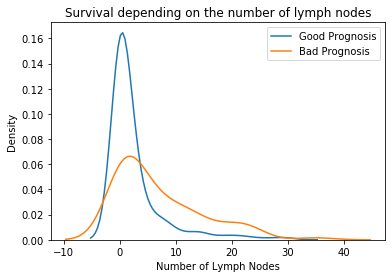

In [10]:
for surv_stat in [1,2]:
    
    sub_data = data[data['Survival Status'] == surv_stat]
    
    sns.kdeplot(sub_data['Number of Lymph Nodes'], label = surv_stat)
    
plt.xlabel('Number of Lymph Nodes'), plt.ylabel('Density');
plt.title('Survival depending on the number of lymph nodes');
plt.legend(labels = ['Good Prognosis', 'Bad Prognosis']);

The data is more informative in this case. There's a good distinction, and it is clear that patients having very low number of lymph nodes are much more likely to survive, while their chances drop drastically if they have more than 10 nodes. 

### Data Preparation

As the data is already clean, we'll just need to perform some minor data preparation. All the features except `Survival Status` will make up the matrix of features, while this feature will be used for as a label. We will rescale just the values of the feature matrix.

Since the dataset is imbalanced, we'll use the stratification in the train/test split, which preserves the minority class ratio in every split.

In [11]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Model Evaluation

As a benchmark to compare our results with, we will use the following table:

Method | Accuracy | Recall | F1 Soce |
-----------|--------|--------|---------|
Logistic Regression | 74.25 | 94.77 | 82.62 |
SVC | 69.77 | 95.42 | 82.71 |
Naive Bayes | 74.17 | 94.11 | 82.52 |

This table is taken from the [Toward Efficient Breast Cancer Diagnosis and Survival Prediction Using L-Perceptron](https://arxiv.org/abs/1811.03016) paper by H. Mansourifar, W. Shi. The scores obtained are by the most straightforward applications of the algorithms, without any data preparation, parameter tuning, stratification, etc.

However, in our case, the most important metric is going to be precision, which measures the false positives (i.e. outcomes which were predicted as good, but turned out bad). They are much more dangerous than the false negatives. That's why, in building our models, we are prepared to sacrfice some accuracy and recall for gaining better precision.

The presented scores are obtained from a 10-fold cross-validation on the entire dataset.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

'''
here we define function for evaluating the model on a single
test set
'''

def model_single_val(model, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size = 0.2,
                                            stratify = y,
                                            random_state = 13)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    acc = accuracy_score(y_test, y_pred)
    acc = round(acc, 6)
    
    class_rep = classification_report(y_test, y_pred,
                                     output_dict=True)['1']
    
    print('confusion matrix:\n', cm)
    print('accuracy:    {}'.format(acc))
    print(pd.Series(class_rep)[:-1])

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

'''
here we define a function for cross-validation;
since the dataset is imbalanced, we will use a stratified cross-val,
where each fold preserves the ratio of the minority class
'''

def model_cv_val(model, X, y):
    
    scores = []
    scoring = ['accuracy','precision','recall','f1']    
        
    cv = StratifiedKFold(n_splits = 10, shuffle=True,
                             random_state = 42)

    metrics = cross_validate(estimator = model, 
                                X = X, y = y,
                                cv = cv, 
                                scoring = scoring)
    
    for score in scoring:
        
        result = metrics['test_' + score].mean()*100
        result = round(result, 2)
        scores.append(score)
        print(score, result)
    
    return scores

In [15]:
from sklearn.model_selection import RandomizedSearchCV

'''
here we defined function for the grid search
'''

def model_grid_search(model, grid, X, y):
    

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42)

    rand_cv = RandomizedSearchCV(estimator=model,
                                param_distributions= grid,
                                n_iter = 128, 
                                scoring = 'precision',
                                n_jobs = -1, cv = cv,
                                return_train_score=True)
    
    rand_cv.fit(X,y)
    
    print('\n The best parameters:\n', rand_cv.best_params_)

### Model 1: Logistic Regression

First we will try out the classification using the logistic regression. Since the dataset is imbalanced, we adjust the class weights. The weights are chosen after some experimentation. Appart from this, we will not tune the other parametes, for now.

In [16]:
#results from a single test set
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight = {1:0.38, 2:1})

model_single_val(log_reg, X, y)

confusion matrix:
 [[41  4]
 [ 6 10]]
accuracy:    0.836066
precision    0.872340
recall       0.911111
f1-score     0.891304
dtype: float64


We obtained good results for a single test set. But let's see what's the performance when we do the cross validation.

In [17]:
#results from a cross-validation
model_cv_val(log_reg, X, y);

accuracy 74.61
precision 82.0
recall 84.76
f1 83.06


Comparing with the bencmark results

Method | Accuracy | Recall | F1 Soce |
-----------|--------|--------|---------|
Logistic Regression | 74.25 | 94.77 | 82.62 |

we see that we have managed to rise accuracy a bit, but significally reduce the recall. Nevertheless, both the F1 score and accuracy have increased, which means that we managed to rise the precision, which is our main goal.

### Model 1 - Hyperarameter Tuning

Let's check if we can improve upon the previous results by performing the hyperparameter tuning. 

In [18]:
#creating the hyperparameter grid
penalty = ['l1', 'l2']
C = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
rand = [ 7, 13, 19, 23, 26, 47, 52, 99, 100, 2020]
solver = ['lbfgs','liblinear','saga']

hyperparameter_grid = {'penalty':penalty,
                      'C':C, 'random_state':rand,
                      'solver':solver}

In [19]:
model_grid_search(log_reg, hyperparameter_grid, X, y)


 The best parameters:
 {'solver': 'liblinear', 'random_state': 2020, 'penalty': 'l2', 'C': 0.01}


Now we will see how our classifier performs with these hyperparameter on a single test set and when doing a cross-validation.

In [23]:
improv_log_reg = LogisticRegression(solver='liblinear', penalty='l2',
                                   C =0.01, random_state=2020,
                                   class_weight={1:0.38, 2:1})

#single test
model_single_val(improv_log_reg, X, y)

confusion matrix:
 [[40  5]
 [ 5 11]]
accuracy:    0.836066
precision    0.888889
recall       0.888889
f1-score     0.888889
dtype: float64


The parameter tuning did improve precision, but let's see how  the cross-validation goes.

In [24]:
#cv test
print('Old results:')
model_cv_val(log_reg, X, y);
print('\nNew results:')
model_cv_val(improv_log_reg, X, y);

Old results:
accuracy 74.61
precision 82.0
recall 84.76
f1 83.06

New results:
accuracy 73.63
precision 82.51
recall 82.09
f1 82.06


We notice some drop in the accuracy and F1 score, but more importantly, there is a small rise for the precision. This is a good improvement if we want to go more towards the precision side in the accuracy-precision trafe-off.

### Model 2 - SVC

Now we'll check out the performance on the support vector classifier. The weights are chosen after some experimentation. Appart from this, we will not tune the other parametes, for now.

In [25]:
#results from a single test set
from sklearn.svm import SVC

svc = SVC(class_weight = {1:0.5, 2:1})

model_single_val(svc, X, y)

confusion matrix:
 [[42  3]
 [ 8  8]]
accuracy:    0.819672
precision    0.840000
recall       0.933333
f1-score     0.884211
dtype: float64


The results with SVC are not as good as with the logistic regression, but let's see how things go with the cross validation.

In [26]:
#results from a cross-validation
model_cv_val(svc, X, y);

accuracy 74.31
precision 80.14
recall 87.04
f1 83.29


If we compare this with the SVC benchmark from the table 

Method | Accuracy | Recall | F1 Soce |
-----------|--------|--------|---------|
SVC | 69.77 | 95.42 | 82.71 |

we see a rise in accuracy and F1 score, and a substantial drop in the recall, which signify that there's a good rise for the precision in our model.

### Model 2 - Hyperparameter Tuning

Let's check if we can improve upon the previous results by performing the hyperparameter tuning. 

In [27]:
#creating the hyperparameter grid
kernel = ['linear', 'rbg', 'sigmoid']
C = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma = ['scale', 'auto']
rand = [7, 13, 19, 23, 26, 52, 47, 99, 100, 2020]

hyperparameter_grid = {'kernel':kernel,
                      'C':C, 'random_state':rand,
                      'gamma':gamma}

In [28]:
model_grid_search(svc, hyperparameter_grid, X, y)


 The best parameters:
 {'random_state': 100, 'kernel': 'linear', 'gamma': 'auto', 'C': 1000}


In [29]:
#performance on a single test set
improv_svc = SVC(kernel = 'linear', gamma = 'auto', C = 1000,
                 random_state = 100,
                 class_weight={1:0.5, 2:1})

#single test
model_single_val(improv_svc, X, y)

confusion matrix:
 [[44  1]
 [ 8  8]]
accuracy:    0.852459
precision    0.846154
recall       0.977778
f1-score     0.907216
dtype: float64


Here we can observe an increase in the accuracy and F1 score. But let's check how the things go with the cross validation.

In [30]:
#cv test
print('Old results:')
model_cv_val(svc, X, y);
print('\nNew results:')
model_cv_val(improv_svc, X, y);

Old results:
accuracy 74.31
precision 80.14
recall 87.04
f1 83.29

New results:
accuracy 75.29
precision 79.71
recall 89.7
f1 84.28


Here we have a rise in the accuracy and F1 score, but some small drop with the precision.

Remark: I have also tried Random Forest Classification with this dataset, but didn't obtain some significant results.

### Using (SVM)SMOTE to handle the imbalanced dataset

In order to use Naive Bayes and Gradient Boosting Classifier we need to artificially augment the data. We will do that by oversampling the minority class using SVMSMOTE strategy. 

In [31]:
#oversampling
from imblearn.over_sampling import SVMSMOTE
oversampler = SVMSMOTE(sampling_strategy = 0.4)
X_smpl, y_smpl = oversampler.fit_resample(X, y)

Using TensorFlow backend.


### Model 3: Naive Bayes

In [32]:
#performance on a single test set
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
model_single_val(gnb, X_smpl, y_smpl)

confusion matrix:
 [[44  1]
 [12  6]]
accuracy:    0.793651
precision    0.785714
recall       0.977778
f1-score     0.871287
dtype: float64


In [33]:
#cross validation
model_cv_val(gnb, X_smpl, y_smpl);

accuracy 74.71
precision 76.64
recall 93.26
f1 84.09


Comparing with the benchmark results, we notice a rise in accuracy and F1 score, followed by a drop in recall. This means that precision has increased. Still the obtained precision is much worse than the one we obtained with the logistic regression, where we didn't even have to dabble with the original dataset. 

Method | Accuracy | Recall | F1 Soce |
-----------|--------|--------|---------|
Naive Bayes | 74.17 | 94.11 | 82.52 |

### Model 4: Gradient Boosting Classifier

In [34]:
#oversampling
from imblearn.over_sampling import SVMSMOTE
oversampler = SVMSMOTE(sampling_strategy = 0.6)
X_smpl, y_smpl = oversampler.fit_resample(X, y)

In [35]:
#single test
from sklearn.ensemble import GradientBoostingClassifier

grad_boost = GradientBoostingClassifier()

model_single_val(grad_boost, X_smpl, y_smpl)

confusion matrix:
 [[37  8]
 [18  9]]
accuracy:    0.638889
precision    0.672727
recall       0.822222
f1-score     0.740000
dtype: float64


In [36]:
#cross validation
model_cv_val(grad_boost, X_smpl, y_smpl);

accuracy 72.63
precision 77.01
recall 81.72
f1 78.99


For now, Naive Bayes gives the better results. Let's see if anything changes with the parameter tuning. 

In [37]:
#creating the hyperparameter grid
loss = ['deviance','exponential']
learning_rate = [1e-4, 1e-3, 1e-2, 1e-1]
n_estimators = [10, 25, 50, 100, 250, 500, 1000]
rand = [7, 13, 19, 23, 26, 52, 47, 99, 100, 2020]
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 8]
max_depth = [2, 3, 4, 5, 6, 10]

hyperparameter_grid = {'loss':loss, 'learning_rate':learning_rate,
                       'n_estimators':n_estimators, 'random_state':rand,
                       'min_samples_leaf':min_samples_leaf,
                       'min_samples_split':min_samples_split,
                       'max_depth':max_depth}

In [38]:
model_grid_search(grad_boost, hyperparameter_grid, X_smpl, y_smpl)


 The best parameters:
 {'random_state': 2020, 'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_depth': 10, 'loss': 'deviance', 'learning_rate': 0.01}


In [39]:
improv_grad_boost = GradientBoostingClassifier(random_state=2020,
                                               n_estimators=1000,
                                               min_samples_split=8,
                                               min_samples_leaf=8,
                                               max_depth=10,
                                               loss='deviance',
                                               learning_rate=0.01)

#single test
model_single_val(improv_grad_boost, X_smpl, y_smpl)

confusion matrix:
 [[33 12]
 [15 12]]
accuracy:    0.625
precision    0.687500
recall       0.733333
f1-score     0.709677
dtype: float64


In [40]:
#cv test
print('Old results:')
model_cv_val(grad_boost, X_smpl, y_smpl);
print('\nNew results:')
model_cv_val(improv_grad_boost, X_smpl, y_smpl);

Old results:
accuracy 72.63
precision 77.01
recall 81.72
f1 78.99

New results:
accuracy 71.47
precision 78.17
recall 76.32
f1 76.98


We notice some good improvement precision-wise. 

### Making Predictions

Using the linear regression model, we will build a fucntion that makes the operation outcome prognosis based on the input data.

In [41]:
def make_prognosis(model):
    
    age = int(input("Enter the patien's age: "))
    oper_yr = int(input("Enter the year of the operation: "))
    lymph_nodes = int(input("Enter the number of lymph nodes found in patent's brests: "))
    
    vec = np.array([[age, oper_yr, lymph_nodes]])
    vec = scaler.transform(vec)
    
    outcome = model.predict(vec)
    
    if outcome == 1:
        print("Good prognosis!")
    else:
        print("Unfortunately, bad prognosis.")

In [42]:
make_prognosis(improv_log_reg)

Enter the patien's age: 56
Enter the year of the operation: 63
Enter the number of lymph nodes found in patent's brests: 6
Unfortunately, bad prognosis.


In [43]:
make_prognosis(improv_log_reg)

Enter the patien's age: 43
Enter the year of the operation: 68
Enter the number of lymph nodes found in patent's brests: 3
Good prognosis!


### Conclusions

Because we worked with small imbalanced dataset, we weren't able to achieve some stellar results. We needed to make a trade-off between the accuracy and precision. We were aiming for a higher precision, while sacrificing some accuracy. Of course, maxing out the precision, while heavily lowering the accuracy was not the option; some balance needs to be present. We also need to mention that when dealing with the medical data, every part of the percent counts, especially when it comes to false good prognosis. 

If high accuracy was our main goal, we might've obtained flashier results (accuracy-wise), but at the heavy expence on the precision. This, given the nature of our problem, could also be interpreted even as dangerous. 

We also tried synthetically augmenting data to counter the imbalance, but this didn't give us some significantly better results. We obtained better results by keeping the original data, and tuning the class weights within the used algorithms.

To finish things off, we will compare the results once more, side by side, in the following tables.


- The `benchmark` row represents the results of the 'raw implementation' of the algorithm, without any dataset interventions and hyperparameter tuning. 

- The `before tuning` are the results from implementing the algorithm after some data modifications and class weights adjustments, but before any hyperparameter tuning.

- The `after tuning` are the results obtained after the parameteres have been tuned.

### Results comparison: the original dataset

$\text{Logistic Regression}$

Results | Accuracy | Precision | Recall | F1 Soce |
-----------|-----------|--------|--------|---------|
Benchmark | 74.25 | N/A | 94.77 | 82.62 |
Before tuning | 74.61 | 82 | 84.76 | 83.06 |
After tuning | 73.63 | 82.51 | 82.09 | 82.06 |



$\text{SVC}$

Results | Accuracy | Precision | Recall | F1 Soce |
-----------|-----------|--------|--------|---------|
Benchmark | 69.77 | N/A | 95.42 | 82.71 |
Before tuning | 74.31 | 80.14 | 87.04 | 83.29 |
After tuning | 75.29 | 79.71 | 89.7 | 84.28 |

-------------------------------------------------
### Results comparison: oversampled dataset

$\text{Naive Bayes}$

Results | Accuracy | Precision | Recall | F1 Soce |
-----------|-----------|--------|--------|---------|
Benchmark | 69.77 | N/A | 95.42 | 82.71 |
Before tuning | 74.71 | 76.64 | 93.26 | 84.09 |



$\text{Gradient Boosting}$

Results | Accuracy | Precision | Recall | F1 Soce |
-----------|-----------|--------|--------|---------|
Before tuning | 72.63 | 77.01 | 81.72 | 78.99 |
After tuning | 71.47 | 78.17 | 76.32 | 79.98 |

We definitely obtain the best results from Logistic Regression and SVC. If we aim straight for the precision, then Logistic Regression is the best model, while SVC is a bit more balanced, and gives better accuracy. 

Naive Bayes also gives fine results, but it requires working with synthetically generated data. 